# **How do I know my LLM is an Effective Evaluator?**

### Overview
The goal of this notebook is to present a repeatable framework to answer the question: How accurate is my LLM when assessing the Coherence, Relevance, or Fluency of my chatbot.  
    
In this demonstration, you will compare LLM assessment of Coherence against human graded samples. This demo uses the SummEval dataset, which contains LLM generated summarizations that have been human graded on Coherence and other metrics. Coherence measures the quality of all sentences in a model's predicted answer and how they fit together naturally.  
  
Two important considerations:  
1. The LLM evaluation can be effectively tuned to using Prompt Engineering techniques  
2. Human analyzed scores - even by an expert - are subjective. This fact should be considered in all analysis.  

You will utilize Azure PromptFlow to generate Coherence evaluations using GPT4. Using PromptFlow you will use two Coherence evauation prompts - a standard template and a template using 'emotion' as referenced in the linked paper below. You will then use this notebooks to compare and analyze the GPT4, GPT4 with emotion, and human graded coherence scores.

 **_Go Deeper_**  
- [Are Large Language Model-based Evaluators the Solution to Scaling Up Multilingual Evaluation?](https://ar5iv.labs.arxiv.org/html/2309.07462)
- [EmotionPrompt: Leveraging Psychology for Large Language Models Enhancement via Emotional Stimulus](https://arxiv.org/pdf/2307.11760v3.pdf)
- SummEval: Re-evaluating Summarization Evaluation [[Paper]](https://arxiv.org/pdf/2007.12626.pdf) / [[Repository]](https://github.com/Yale-LILY/SummEval#data)  
  
**_Prerequisites_**  

Ensure that your environment is setup by completing the steps outlines in [0_setup.ipynb](./0_setup.ipynb)  
_Optional_: For an overview of GPT based metrics, please see [1_gpt_evaluation.ipynb](./1_gpt_evaluation.ipynb)

### Step 1: Examine Input Data
The SummEval dataset provides human labeled analysis on LLM generated summaries.The annotations include summaries generated by 16 models from 100 source news articles (~15000 examples in total). You will use a subset of ~250 samples.
Each of the summaries was annotated by 5 indepedent crowdsource workers and 3 independent experts (8 annotations in total).
Summaries were evaluated across 4 dimensions: coherence, consistency, fluency, relevance.
Each source news article comes with the original reference from the CNN/DailyMail dataset and 10 additional crowdsources reference summaries.  
  
Take a look at the data [summEval_human_labeled.jsonl](../data/inputs/summEval_human_labeled.jsonl)  

### Step 2: Run Evaluation Pipeline

**IMPORTANT:** Be sure to analyze and expirament with the [gpt_eval_benchmark](../src/promptflow/evaluation_flows/gpt_eval_benchmark/) PromptFlow used in this step.  
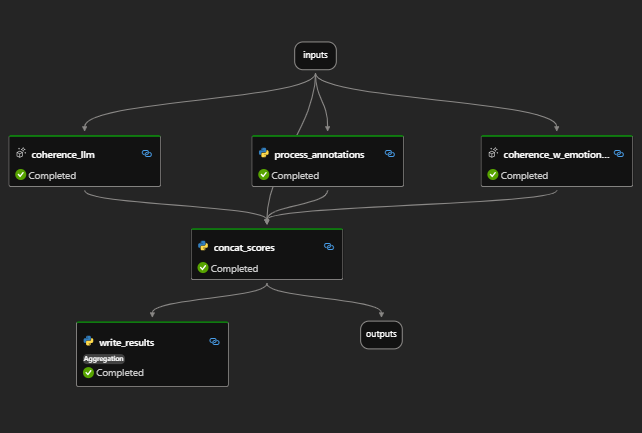
  
  _This step may take upt to 10 minutes to complete_

In [9]:
from promptflow import PFClient

# PFClient can help manage your runs and connections.
pf = PFClient()

# Define Flows and Data
eval_flow = "../src/promptflow/evaluation_flows/gpt_eval_benchmark" # set flow directory
data = "../data/inputs/summEval_human_labeled_subset.jsonl" # set the data file

# Run evaluation flow to evaluate chat results
eval_run = pf.run(
    flow=eval_flow,
    data=data,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "expert_annotations": "${data.expert_annotations}",
      "turker_annotations": "${data.turker_annotations}",
      "response": "${data.decoded}",
    }
)

[2023-12-13 14:42:12,589][promptflow._sdk._submitter.run_submitter][WARNING] - 2 out of 249 runs failed in batch run. Please check out /home/zacksoenen/.promptflow/.runs/gpt_eval_benchmark_variant_0_20231213_143631_407357 for more details.


Helpful Documentation:  
[Run and Evaluate a PromptFlow](https://microsoft.github.io/promptflow/how-to-guides/run-and-evaluate-a-flow/index.html)  
[PFClient Documentation](https://microsoft.github.io/promptflow/reference/python-library-reference/promptflow.html)

### Step 3: Analyze Outputs

In [2]:
import pandas as pd

output_data = "../data/outputs/gpt_benchmark_results.json"

output_df = pd.read_json(output_data)
display(output_df)

,response,gpt_coherence,gpt_coherence_w_emotion,expert_coherence,turker_coherence
0,paul merson was brought on with only seven min...,3,3,1,3
1,paul merson has restarted his row with andros ...,4,5,2,2
2,paul merson has restarted his row with andros ...,5,5,2,4
3,paul merson has restarted his row with andros ...,4,4,2,5
4,paul merson has restarted his row with andros ...,5,5,3,2
...,...,...,...,...,...
242,world no 1 williams said her struggle to beat ...,4,5,2,5
243,serena williams said her struggle to beat sara...,5,5,4,1
244,twice french open champion serena williams sai...,5,5,4,4
245,serena williams beat sara errani 4-6 7-6(3) 6-...,5,5,2,3


#### On average, there is about a 1.5 point raiting difference between our GPT scores and the expert/turker analysis.

In [5]:
#Calculate the RMSE of each prompt against expert and turker scores

# gpt_vs_expert
gpt_expert_rmse = ((output_df['gpt_coherence'] - output_df['expert_coherence'])**2).mean()**.5
# gpt_vs_turker
gpt_turker_rmse = ((output_df['gpt_coherence'] - output_df['turker_coherence'])**2).mean()**.5
# gpt_w_emotion_vs_expert
gpt_w_emotion_expert_rmse = ((output_df['gpt_coherence_w_emotion'] - output_df['expert_coherence'])**2).mean()**.5
# gpt_w_emotion_vs_turker
gpt_w_emotion_turker_rmse = ((output_df['gpt_coherence_w_emotion'] - output_df['turker_coherence'])**2).mean()**.5

print(f"RESULTS:\nGPT/Expert: {gpt_expert_rmse}\nGPT/Turker: {gpt_turker_rmse}\nGPT+Emotion/Expert: {gpt_w_emotion_expert_rmse}\nGPT+Emotion/Turker: {gpt_w_emotion_turker_rmse}")


RESULTS:
GPT/Expert: 1.5650535813672986
GPT/Turker: 1.4689774459950382
GPT+Emotion/Expert: 1.5830580767912235
GPT+Emotion/Turker: 1.4606858796012223


In [39]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=output_df['gpt_coherence'], name='gpt_coherence'))
fig.add_trace(go.Histogram(x=output_df['gpt_coherence_w_emotion'], name='gpt_coherence_w_emotion'))
fig.add_trace(go.Histogram(x=output_df['expert_coherence'], name='expert_coherence'))
fig.add_trace(go.Histogram(x=output_df['turker_coherence'], name='turker_coherence'))


# The two histograms are drawn on top of another
fig.update_layout(barmode='group', title_text='Rating Distributions by Grader Type')
fig.show()

Based on our preliminary results, there seems to be a tendency for GPT to rate coherence higher than a crowdsourced (turker) grader and expecially higher than an expert. However, when {4-5} and {1-2} ratings are bucketed together, GPT ratings more closely align with our turker average.

Another observation: there is not much difference between the two GPT based metrics.

In [36]:
output_df['gpt-expert'] = output_df['gpt_coherence'] - output_df['expert_coherence']
output_df['gpt_we-expert'] = output_df['gpt_coherence_w_emotion'] - output_df['expert_coherence']


fig = go.Figure()
fig.add_trace(go.Histogram(x=output_df['gpt-expert'], name='GPT minus Expert'))
fig.add_trace(go.Histogram(x=output_df['gpt_we-expert'], name='GPT w/ Emotion minus Expert'))


# The two histograms are drawn on top of another
fig.update_layout(barmode='group', title_text='Difference in Ratings: GPT vs Expert')
fig.show()

Note the heavy skew - this confirms our observations that our GPT metrics tend to score more positively than a human expert.

In [38]:
output_df['gpt-turker'] = output_df['gpt_coherence'] - output_df['turker_coherence']
output_df['gpt_we-turker'] = output_df['gpt_coherence_w_emotion'] - output_df['turker_coherence']
fig = go.Figure()
fig.add_trace(go.Histogram(x=output_df['gpt-turker'], name='GPT minus Turker'))
fig.add_trace(go.Histogram(x=output_df['gpt_we-turker'], name='GPT w/ Emotion minus Turker'))


# The two histograms are drawn on top of another
fig.update_layout(barmode='group', title_text='Different in Ratings: GPT vs Turker')
fig.show()

Althought there is still a skew - it is not as severe as the above graphic. However, our GPT metrics still tend to overestimate compared to crowdsourced humans.

Let's take a look at an example where GPT was +4 points greater than our turker grade:

In [48]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(output_df.loc[(output_df['gpt-turker'] == 4) & (output_df['gpt_we-turker'] == 4)][['response','gpt_coherence','gpt_coherence_w_emotion','expert_coherence','turker_coherence']].head(1))

,response,gpt_coherence,gpt_coherence_w_emotion,expert_coherence,turker_coherence
5,paul merson has restarted his row with andros townsend after the tottenham midfielder was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley . merson initially angered townsend for writing in his sky sports column that ` if andros townsend can get in -lrb- the england team -rrb- then it opens it up to anybody . ' paul merson had another dig at andros townsend after his appearance for tottenham against burnley .,5,5,4,1


## **Bonus Challenge:**  
See if you can create or edit a Coherence evaluation prompt to more closely resemble the Expert annotations! Re-run the PromptFlow, then re-run (or create your own) analysis to test your theory!
- Easiest path: Start by editing the evaluation prompt [here](../src/promptflow/components/coherence_with_emotion.jinja2)